# Ground-Based High-Resolution Transmission Spectroscopy (Cross Correlation)

Welcome to this tutorial on high-resolution cross-correlation spectroscopy of exoplanets. Some parts of this tutorial are adopted from ESO workshop on 08/23/2021.

This tutorial covers how to cross correlate your high resolution data with forward model templates using POSEIDON. We will reproduce the result from [Gibson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.4618G/abstract), showing a strong Fe detection on WASP-121b using cross-correlation.

You should run this tutorial before running the transmission high resolution retrieval tutorial notebook, where we will demonstrate how to set up a high-resolution retrieval.

Although focused on transit transmission spectroscopy in the optical, these concepts also apply to day-side emission spectra and infrared wavelengths. See the [\"Ground-Based High-Resolution Emission Spectroscopy (Cross Correlation)\"](emission_high_res_cross_correlate.html) tutorial to learn more.


We'll make use of:

* Spectral orders extracted and processed as described in [Gibson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.4618G/abstract).
* Wavelength solutions.
* The orbital phases of the time series.
* The line-of-sight velocity of Earth with respect to the barycenter during the time series (barycenteric velocity). We don't have to worry about it in this dataset because we have shifted the data into the rest frame of the barycenter.
* POSEIDON's forward model.

![title](../../_static/notebook_images/high_res_trans.png)

The Earth's transmission spectrum longward of 1 micron becomes severely affected by the absorption of molecular species in our own atmosphere, primarily water vapour (H<sub>2</sub>O), but also methane (CH<sub>4</sub>) and carbon dioxide (CO<sub>2</sub>). An example of this can be seen in a model transmission spectrum calculated with the [ESO Sky Model Calculator](https://www.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC) (R=20,000, zenith, 2.5 mm of precipitable water vapour, average yearly conditions at Cerro Paranal).

![Earth's transsmission spectrum](../../_static/notebook_images/high_res_Earth_trans.gif)

Such dominance of telluric lines (telluric = "of the Earth") requires a different approach than for optical spectra. In the cell below, we read the raw data, remove outliers, applying blaze correction, fit uncertainties to the data according to Gibson et al. 2022, and finally apply Sysrem algorithm to extract the signals.

## Loading WASP-121b Transmission Data

First, we will load the high resolution data for your planet (WASP-121b in our case).


NOTE: explain to readers that they don't need a data_raw.hdf5 file, they just to to read in the four arrays below.


Your data should include
1. raw flux from the observation, This should be a 3D array: NOrders x NExposures x NPixels.
2. wavelength grid of your observations. This should be a 2D array: NOrders x Npixels.
3. orbital phase of each exposure. This should be a 1D array: NExposures.
4. transit weight of each exposure. The value should ne 1 before and after transit; transit depth in mid-transit. This should be a 1D array: NExposures.

Suppose this is the first time you use POSEIDON on this dataset. We will read the dataset in its raw form, processes it, and save it into POSEIDON compatible format (.hdf5).

Reminder: POSEIDON calculates spectra in vacuum wavelengths. If your data come in air wavelengths, you could use POSEIDON.high_res.airtovac for wavelength conversion.

In [ ]:
from POSEIDON.high_res import remove_outliers, blaze_correction, fit_uncertainties, \
                              prepare_high_res_data, read_hdf5

data_dir = '../../../POSEIDON/reference_data/observations/WASP-121b'   

names = ["blue"] # only use blue arm for demo purposes
# Change to the line below to use both blue and red arms.
# names = ["blue", "redl", "redu"]

# This is how you combine multiple datasets together.
# It could be different nights of observations or even data from different instruments.
# In this case, we are combining different arms of the same instrument.

In [2]:
for i in range(len(names)):

    # Read in the raw data
    data_raw = read_hdf5(data_dir + "/" + names[i] + "/data_raw.hdf5")

    # Read different fields of the data
    flux = data_raw["flux"]
    wl_grid = data_raw["wl_grid"]
    phi = data_raw["phi"]
    transit_weight = data_raw["transit_weight"]
    
    # Remove outliers, correct for blaze, and fit uncertainties, as described in the paper
    flux = remove_outliers(wl_grid, flux)
    flux = blaze_correction(flux, filter_size=(500, 100))
    uncertainties = fit_uncertainties(flux, n_components=5)

    # Prepare the data iand save it to data_processed.hdf5. This file contains all the data needed for the high-res analysis.
    # This cell only needs to be run once for each dataset. After you have the processed data, you can run from the cell below next time.
    prepare_high_res_data(data_dir, names[i], "transmission", "sysrem",
                          flux, wl_grid, phi, uncertainties, transit_weight,
                          sysrem_niter = 10)

/home/ryanmacdonald/anaconda3/envs/POSEIDON_python_3.11/lib/python3.11/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


2078 outliers removed from a total of 9302280 pixels
Blaze correcting data with median filter size 500 and gaussian filter size 100
Fitting Poisson uncertainties with 5 components
Creating processed data at ../../../POSEIDON/reference_data/observations/WASP-121b/blue/data_processed.hdf5
Filtering out systematics using SYSREM with 10 iterations


Let's plot the raw data first.

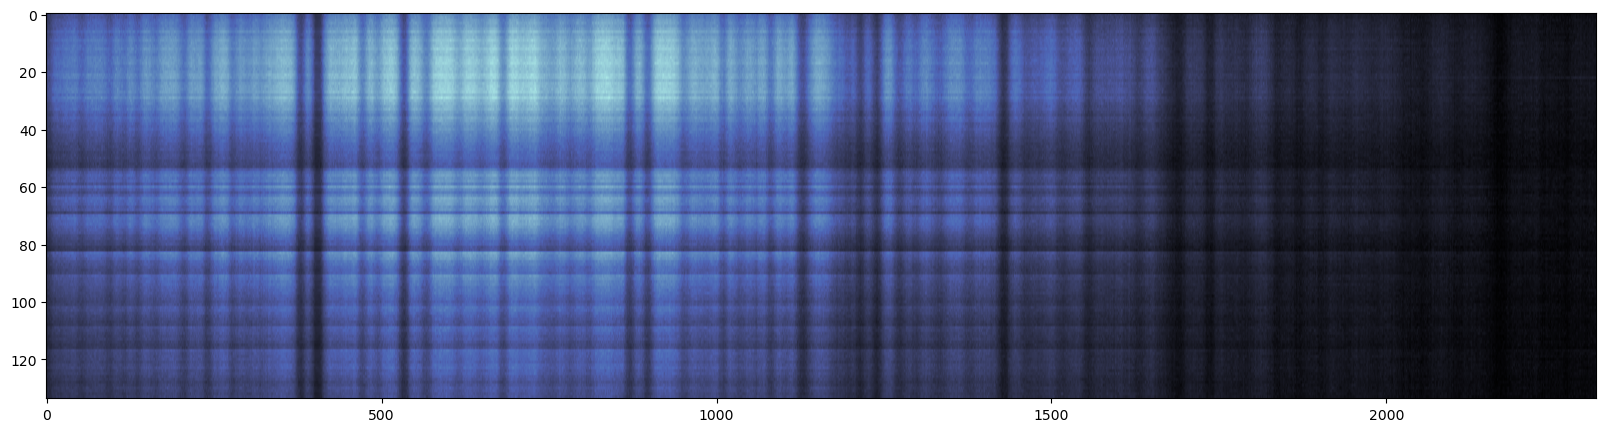

In [3]:
import matplotlib.pyplot as plt
import cmasher as cmr

data_raw = read_hdf5(data_dir + "/blue/data_raw.hdf5")
plt.figure(figsize=(20, 5))
plt.imshow(data_raw["flux"][15], aspect="auto", cmap=cmr.sapphire)

In [4]:
from POSEIDON.high_res import read_high_res_data

# Reading processed data. data is a dictionary containing all the data needed for the high-res analysis.
data = read_high_res_data(data_dir, names=names)

print(data["blue"].keys()) # Look at what's in the processed data. Bs stores the filtering matrices described in the paper: B = U (L U)^(-1) L, where L is a diagonal matrix with 1/σ.

dict_keys(['Bs', 'phi', 'residuals', 'transit_weight', 'uncertainties', 'wl_grid'])


Now we have processed the data, let's take a look at what the residuals look like for order 15. Since the planet-to-star signal ratio is low, we can's see the planet signal by eye.

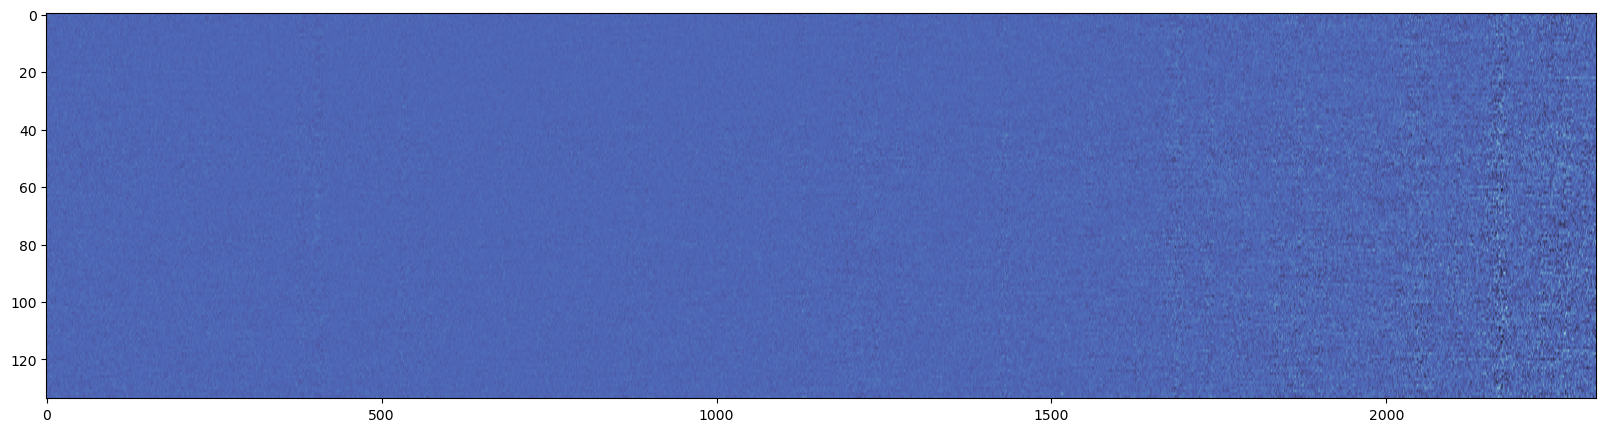

In [5]:
plt.figure(figsize=(20, 5))
plt.imshow(data["blue"]["residuals"][15], aspect="auto", cmap=cmr.sapphire)

## Configuring the Forward Model

Below, we are setting up POSEIDON's forward model. This includes specifying the the properties of the star-planet system, which chemical species we want to include, the resolution at which we calculate the model, and the temperature-pressure profile of our model atmosphere.

Here we set the spectral resolution to be R=250,000. This is a tradeoff between speed (also RAM) and accuracy. Because our high-dispersion data usually has R ≥ 25,000, empirically we want our model to be 10 times more refined than the data such that when binned down to data resolution, it retains high accuracy.

For tutorials on POSEDION's forward model, see the [\"Generating Transmission Spectra\"](transmission_basic.html) tutorial. For more advanced usage, such as including clouds in the atmosphere, see the [\"Clouds In Transmission Spectra\"](transmission_clouds.html).

In [12]:
from POSEIDON.core import create_star, create_planet, read_opacities, compute_spectrum, \
                          define_model, wl_grid_constant_R, make_atmosphere
from POSEIDON.constants import R_Sun, R_J, M_J
import numpy as np

R_s = 1.458 * R_Sun  # Stellar radius (m)
T_s = 6776           # Stellar effective temperature (K)
Met_s = 0.13         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.24       # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, stellar_grid = "phoenix")

# ***** Define planet properties *****#

planet_name = "WASP-121b"  # Planet name used for plots, output files etc.

#R_p = 0.118 * R_s  # Planetary radius (m)
R_p = 1.753 * R_J       # Planetary radius (m) 
M_p = 1.157 * M_J       # Mass of planet (kg)
g_p = 10 ** (2.97 - 2)  # Gravitational field of planet (m/s^2)
T_eq = 2450             # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, gravity = g_p, T_eq = T_eq)

In [ ]:
# ***** Define model *****#

model_name = "Fe"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["Fe"]

model = define_model(model_name, bulk_species, param_species, PT_profile="isotherm",
                    # cloud_model="MacMad17", cloud_type="deck",    # Uncomment if you want to enable clouds in the model
                     )

# ***** Wavelength grid *****#

wl_min = 0.37   # Minimum wavelength (um)
#wl_max = 0.51  # Maximum wavelength (um) for blue arm
wl_max = 0.87   # Maximum wavelength to also include red arm
R = 250000      # Spectral resolution of the model wavelength grid
                # Note: for high-res data, the resolution of the grid is recommended 
                # to be 10x higher than the data. Since we are dealing with high-res data 
                # with R~80,000, R=250,000 is a good tradeoff between RAM, computational speed and accuracy

# Create wavelength grid
wl = wl_grid_constant_R(wl_min, wl_max, R)

In [8]:
# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
# Since we are calculating an isothermal atmosphere, we just need the opacity 
# at a single temperature, so a narrow temperature range is fine
T_fine_min = 2900
T_fine_max = 3100
T_fine_step = 50

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
# Even though we will model atmospheres down to 10^-12 bar, the lowest pressure 
# in the opacity database is 10^-6 bar, so there is no need for the fine grid
# to extend to lower pressures (the cross sections at 10^-6 bar already have
# essentially no pressure broadening)
log_P_fine_min = -6.0    # 10^-6 bar is the lowest pressure in the opacity database
log_P_fine_max = 2.0     # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2    # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
Fe done
Opacity pre-interpolation complete.


In [9]:
# Specify the pressure grid of the atmosphere
P_min = 1.0e-12  # 10^-12 bar
P_max = 100      # 100 bar
N_layers = 100   # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1.0e-2   # Reference pressure (bar)
R_p_ref = R_p    # Radius at reference pressure


# Provide a specific set of model parameters for the atmosphere
PT_params = np.array([3000.0])    # Isothermal temperature (K)  
log_X_params = np.array([-5.0])   # log10(Fe) mixing ratio 
# cloud_params = np.array([0])    # Optional: log10(cloud top pressure / bar)

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params)

# Generate planetary transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, 
                            wl, spectrum_type = 'transmission')

Let's take a look at the model spectrum we just calculated. The first figure below shows the calculated spectrum at raw resolution R=250,000 and the spectrum binned down to data resolution. We can see forests of Fe lines in this wavelength range.

The second figure shows a spectrum binned down to R=1000. We see the line depths significantly decrease comparing to the model at raw resolution. This is why we can't do cross-correlation analysis at low resolution! Remember the correlation is directly proportional to the number of lines and the line depth.

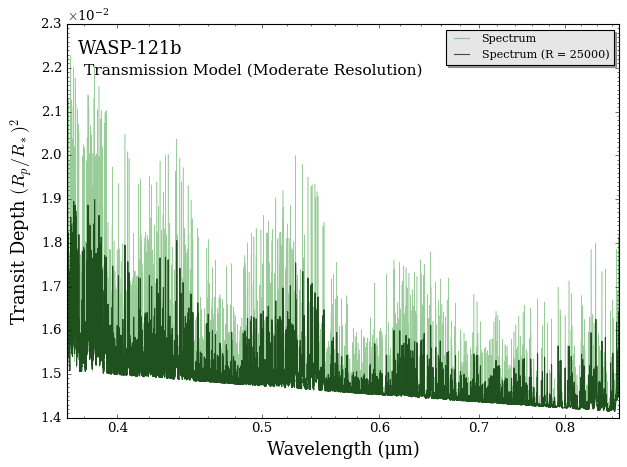

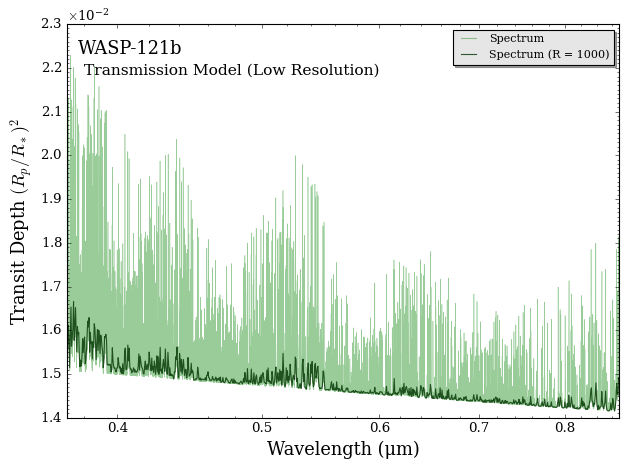

In [11]:
from POSEIDON.utility import plot_collection
from POSEIDON.visuals import plot_spectra

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = [])

fig = plot_spectra(spectra, planet, bin_spectra = True, R_to_bin = 25000, 
                   plt_label = 'Transmission Model (Moderate Resolution)')
fig = plot_spectra(spectra, planet, bin_spectra = True, R_to_bin = 1000, 
                   plt_label = 'Transmission Model (Low Resolution)')

## Cross-Correlation

Cross correlation has been used in various flavours since the first application in [Snellen et al. 2010](https://www.nature.com/articles/nature09111). In this example, we use the following definition:


$$
CCF(v,t) = \sum_i^N \frac{ f_i(t) m_i(v)}{\sigma_i^2}
$$

Here, $m_i$ is the template shifted to a radial velocity $v$. $f_i$ is the residual observed at time $t$. $m_i$ is now defined on the same grid as $f_i$ through interpolation. $C$ then is a 2-dimensional matrix, as function of time along the transit and the radial velocity shift of the template. At the correct combination of time and velocity, the signal of the planet should appear.

Let's cross-correlate our template model with the data!

In [ ]:
from POSEIDON.high_res import cross_correlate

Kp_range = np.arange(-300, 301, 1)
Vsys_range = np.arange(-200, 201, 1)
RV_range = np.arange(-500, 501, 1) # Set RV range to (min(Kp)+min(Vsys), max(Kp)+max(Vsys))

# Phase-folding the cross-correlation function on all datasets
CCF_Kp_Vsys_all = []
CCF_phase_RV_all = []

# Loop through all the data sets (blue, redl, redu) and cross correlate them with the model spectrum
for key in data.keys():
    CCF_Kp_Vsys, CCF_phase_RV = cross_correlate(Kp_range, Vsys_range, RV_range, wl, spectrum, data[key])
    CCF_Kp_Vsys_all.append(CCF_Kp_Vsys)
    CCF_phase_RV_all.append(CCF_phase_RV)

CCF_phase_RV_all = np.array(CCF_phase_RV_all)
CCF_Kp_Vsys_all = np.array(CCF_Kp_Vsys_all)

Cross correlation took 20.058603286743164 seconds


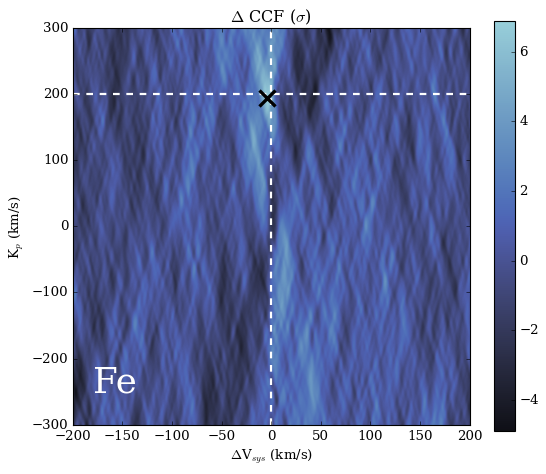

In [ ]:
from POSEIDON.high_res import plot_CCF_Kp_Vsys

# Plotting the CCF_Kp map after summing up all the datasets
plot_CCF_Kp_Vsys(Kp_range, Vsys_range, CCF_Kp_Vsys=np.sum(CCF_Kp_Vsys_all[:], axis=0),
                 label="Fe", Kp_expected=200, Vsys_expected=0, RM_mask_size=50,
                 plot_slice=True, save_file_path=None, cmap=cmr.sapphire) # Use sapphire colormap for consistency with the paper

Below we plot CCF as a function of $V_p$ and phase $\phi$. Ideally, we could see a trail with slope $\approx K_p$ and $V_p(\phi=0) \approx V_{sys}$ in the CCF space. Phase-folding this plot given a $K_p$ gives rise to one single row in the $K_p-V_{sys}$ plot above.

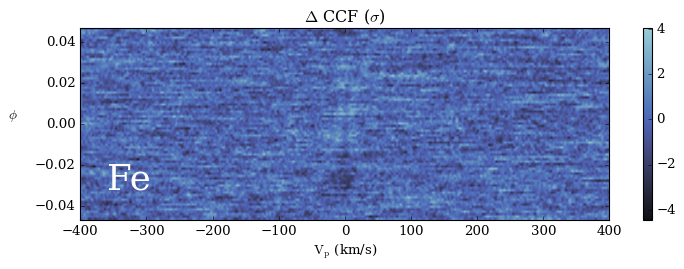

In [ ]:
from POSEIDON.high_res import plot_CCF_phase_RV

transit_model = data["blue"]["transit_weight"]
in_transit = transit_model != 1
phi = data["blue"]["phi"][in_transit]

# Plotting the CCF_phase_RV map after averaging over all the datasets
plot_CCF_phase_RV(phi, RV_range, CCF_phase_RV=np.mean(CCF_phase_RV_all, axis=0)[in_transit],
                  label="Fe", save_file_path=None, cmap=cmr.get_sub_cmap("cmr.sapphire", 0.1, 0.9))

If you see a signal to noise ratio around 6 in the first plot and no visible trail in the second plot, this is expected. There are several reasons the detection strength is less than what's reported in [Gibson et al. 2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.4618G/abstract). After all, the template model in this tutorial is very simplified: isothermal at T=3000K, constant mixing ratio $\log_{10}(X_{Fe}) = -5$. We have not considered potential existence of clouds, nor have we used the red arm of the data (see comments in the first code cell). We have also arbitrarily used 15 iterations of Sysrem, and there are studies showing detection strength can be optimized on number of iterations.

If you have a high-resolution dataset in hand, feel free to experiment with how detection strength vary with different choices by modifying this notebook! And now that you have run through this tutorial, you are ready to move to transmission_high_res_retrieval.ipynb and run your retrievals! Note that the retrieval tutorial is ready to run once you've run the first cell and have data_processed.hdf5 saved.

The figure below is what the residuals would look like if the planet signal is enhanced.

![title](../../_static/notebook_images/high_res_residual_signal.png)